## Заголовок

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import warnings
import pickle
import os

import numpy as np
from shapely.geometry import Polygon
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from blocksnet import City, Provision, ProvisionMethod

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


In [ ]:
data_path = 'data/blocksnet_data/spb/'
blocks = gpd.read_file('data/data_lu/blocks_best_feature.gpkg')

with open(data_path + 'accessibility_matrix.pickle', 'rb') as f:
    accessibility_matrix = pickle.load(f)

gdf = gpd.read_parquet(data_path + 'blocks.parquet')

# Проверка типа
print(type(accessibility_matrix))
print(type(gdf))

In [ ]:
city = City.from_pickle(data_path+'model.pickle')
print(city)

In [ ]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

# Get the maximum index from existing services to ensure a unique new index
max_index = city.get_services_gdf().index.max() if len(city.get_services_gdf()) > 0 else 0

# Create a new service with only the required columns
new_service = gpd.GeoDataFrame(
    {
        # Only include required and optional columns as per the method documentation
        'geometry': [Point(336127.576, 6625035.329)],
        'capacity': [800],  # Optional
        'area': [500]       # Optional
    },
    index=[max_index + 1],  # Use a new unique index
    crs=city.crs  # Must match the city's CRS
)

# use the new service directly if you're replacing all services of this type
# Update the services - make sure 'school' is a valid ServiceType in your system
city.update_services('school', new_service)


In [ ]:
city.get_services_gdf()[city.get_services_gdf()['block_id'] == 14171]

In [ ]:
provision = Provision(city_model=city)
service_type_school = city['school']
service_type_park = city['park']
result_school = provision.calculate(service_type_school, method=ProvisionMethod.GRAVITATIONAL)
result_park = provision.calculate(service_type_park, method=ProvisionMethod.GRAVITATIONAL)

In [ ]:
result_school.fillna(0, inplace=True)
result_park.fillna(0, inplace=True)

In [ ]:
result = result_park[['geometry', 'provision']].set_index('geometry').join(result_school[['geometry', 'provision']].set_index('geometry'), on='geometry', how='left', rsuffix='_school')
result.rename({'provision': 'provision_park'}, inplace=True, axis=1)

blocks = gdf.set_index('geometry').join(result, on='geometry', how='left')
blocks.reset_index(inplace=True)
blocks = gpd.GeoDataFrame(blocks, crs=gdf.crs, geometry='geometry')

## Расчет вероятностей

In [ ]:
def compute_geometric_features(gdf):
    """
    Вычисление геометрических характеристик, включая количество вершин.
    """
    # Вычисляем стандартные характеристики
    gdf['compactness'] = (4 * np.pi * gdf['site_area']) / (gdf['perimeter'] ** 2)
    gdf['bounding_box'] = gdf['geometry'].apply(lambda x: x.minimum_rotated_rectangle)

    def calculate_length_and_width(polygon):
        coords = list(polygon.exterior.coords)
        side_lengths = [np.linalg.norm(np.array(coords[i]) - np.array(coords[i - 1])) for i in range(1, len(coords))]
        return max(side_lengths), min(side_lengths)

    gdf[['length', 'width']] = gdf['bounding_box'].apply(lambda x: pd.Series(calculate_length_and_width(x)))

    gdf['centroid_x'] = gdf['geometry'].centroid.x
    gdf['centroid_y'] = gdf['geometry'].centroid.y

    gdf['area_perimeter_ratio'] = gdf['site_area'] / gdf['perimeter']

    def count_vertices(geometry):
        if geometry.is_empty or geometry is None:
            return 0
        if geometry.type == 'Polygon':
            return len(geometry.exterior.coords)
        if geometry.type == 'MultiPolygon':
            return sum(len(polygon.exterior.coords) for polygon in geometry.geoms)
        return 0

    gdf['vertex_count'] = gdf.geometry.apply(count_vertices)
    gdf['convex_hull'] = gdf['geometry'].convex_hull
    gdf['convex_hull_area'] = gdf['convex_hull'].area
    gdf['convexity_ratio'] = gdf['site_area'] / gdf['convex_hull_area']
    gdf['centroid_distance_from_origin'] = np.sqrt(gdf['centroid_x']**2 + gdf['centroid_y']**2)

    return gdf.drop(columns=['bounding_box', 'convex_hull'])

def compute_landuse_shares(gdf, buffer_distance=500, landuse_col='land_use'):
    gdf = gdf.reset_index(drop=True)
    sindex = gdf.sindex
    shares_list = []

    for idx, row in gdf.iterrows():
        geom = row.geometry
        buffer = geom.buffer(buffer_distance)

        possible_matches_index = list(sindex.intersection(buffer.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        neighbors = possible_matches[possible_matches.index != idx]
        neighbors = neighbors[neighbors.geometry.intersects(buffer)]

        landuses = neighbors[landuse_col]
        total = len(landuses)

        if total > 0:
            landuse_counts = Counter(landuses)
            landuse_shares = {f"{k}_share": v / total for k, v in landuse_counts.items()}
        else:
            landuse_shares = {}

        shares_list.append(landuse_shares)

    shares_df = pd.DataFrame(shares_list).fillna(0)
    return pd.concat([gdf, shares_df], axis=1)



In [ ]:
blocks['perimeter'] = blocks.geometry.length

In [ ]:
blocks = compute_geometric_features(blocks)
blocks = compute_landuse_shares(blocks)


In [ ]:
new = blocks[['site_area','gsi', 'osr',
              'mxi','land_use', 'compactness','vertex_count',
              'convexity_ratio','residential_share', 'transport_share',
              'industrial_share','business_share', 'agriculture_share',
              'special_share','recreation_share',]].copy()

cols_to_fill = ['gsi', 'osr', 'mxi']
new[cols_to_fill] = new[cols_to_fill].fillna(0)


In [ ]:
# Удаляем строки с пропущенным land_use
df = new.dropna(subset=['land_use']).copy()

# Удалим geometry и id, чтобы не мешали
# df = df.drop(columns=['geometry', 'best_example'])

# Категориальную переменную переведём в числовую
df['land_use'] = df['land_use'].astype('category')
df['land_use_code'] = df['land_use'].cat.codes

X = df.drop(columns=['land_use', 'land_use_code'])
y = df['land_use_code']
y_not_code = df['land_use']

X = X.fillna(X.median(numeric_only=True))

In [ ]:
scaler = StandardScaler()
X_index = df.index
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X_index)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
model = CatBoostClassifier(
    iterations=4000,
    learning_rate=0.01,
    l2_leaf_reg=2,
    depth=9,
    random_seed=777,
    verbose=500,           # отключает лог CatBoost
    auto_class_weights='Balanced'  # аналог class_weight='balanced'
)

model.fit(X_train, y_train)


In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df['land_use'].cat.categories))

In [ ]:
# Предсказанные вероятности для всех объектов X_scaled
probas = model.predict_proba(X_scaled)

# Получаем категории land_use (например, 'agriculture', 'business', 'industrial', ...)
class_labels = df['land_use'].cat.categories

# Создаём DataFrame с вероятностями, используя индексы исходного DataFrame (df)
proba_df = pd.DataFrame(probas, 
                        columns=[f'prob_{cls}' for cls in class_labels],
                        index=df.index)
merged_fin = blocks.join(proba_df, how='left')


# Добавляем колонку с наиболее вероятной меткой класса
# Находим индекс максимальной вероятности для каждой строки
prob_columns = [f'prob_{cls}' for cls in class_labels]
merged_fin['most_probable_class_idx'] = merged_fin[prob_columns].values.argmax(axis=1)

# Преобразуем индекс в метку класса
merged_fin['most_probable_class'] = merged_fin['most_probable_class_idx'].apply(
    lambda idx: class_labels[idx] if pd.notna(idx) else None
)

# Если нужно, можно удалить вспомогательную колонку с индексом
merged_fin.drop('most_probable_class_idx', axis=1, inplace=True)

# Добавляем колонку с максимальной вероятностью
merged_fin['max_probability'] = merged_fin[prob_columns].max(axis=1)

In [ ]:
blocks = blocks.set_index('geometry').join(merged_fin[['prob_agriculture','prob_business',
            'prob_industrial','prob_recreation',
            'prob_residential','prob_special',
            'prob_transport','most_probable_class',
            'max_probability','geometry']].set_index('geometry'),
            on='geometry', how='left')

blocks.reset_index(inplace=True)
blocks = gpd.GeoDataFrame(blocks, crs=gdf.crs, geometry='geometry')

## Проверка результатов

In [ ]:
# OLD
viborka = ['geometry', 'prob_recreation', 'prob_business', 'most_probable_class', 'land_use', 'provision_park', 'provision_school']
blocks[blocks['land_use'] != 'transport'].dropna(subset=['land_use'])[viborka].round(3).explore('provision_school')


In [ ]:
# NEW
viborka = ['geometry', 'prob_recreation', 'prob_business', 'most_probable_class', 'land_use', 'provision_park', 'provision_school']
blocks[blocks['land_use'] != 'transport'].dropna(subset=['land_use'])[viborka].round(3).explore('provision_school')

In [ ]:
blocks[blocks['land_use'] != 'transport'].dropna(subset=['land_use'])[viborka].reset_index().round(3).explore('prob_business')


In [ ]:
blocks

## Создание графа (пока не нужно)

In [ ]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Step 1: Calculate centroids for each polygon
merged_fin['centroid'] = merged_fin.geometry.centroid

# Step 2: Find adjacent polygons
# Create a spatial index for efficient spatial queries
spatial_index = merged_fin.sindex

# Function to find adjacent polygons
def find_neighbors(gdf):
    neighbors = {}
    for idx, geom in enumerate(gdf.geometry):
        # Buffer slightly to catch polygons that touch at points
        # or have very small gaps due to numerical precision
        buffered = geom.buffer(0.0001)
        
        # Find potential neighbors using spatial index
        potential_neighbors = list(spatial_index.intersection(buffered.bounds))
        
        # Remove self from potential neighbors
        if idx in potential_neighbors:
            potential_neighbors.remove(idx)
        
        # Check for actual intersection/touching
        neighbors[idx] = [
            neigh_idx for neigh_idx in potential_neighbors
            if geom.touches(gdf.geometry.iloc[neigh_idx]) or 
               geom.intersects(gdf.geometry.iloc[neigh_idx])
        ]
    
    return neighbors

# Get the neighbors dictionary
neighbors_dict = find_neighbors(merged_fin)

# Step 3: Create a graph
G = nx.Graph()

# List of probability columns
prob_columns = [
    'prob_agriculture',
    'prob_business',
    'prob_industrial',
    'prob_recreation',
    'prob_residential',
    'prob_special',
    'prob_transport'
]

# Add nodes with positions based on centroids and probability information
for idx, row in merged_fin.iterrows():
    # Create a dictionary of probability values
    prob_dict = {col: row[col] if col in row and not pd.isna(row[col]) else 0.0 
                for col in prob_columns}
    
    # Add node with all attributes
    G.add_node(idx, 
               pos=(row.centroid.x, row.centroid.y),
               geometry=row.geometry,
               land_use=row.land_use,
               **prob_dict,  # Add all probability columns
               most_probable_class=row.get('most_probable_class', None),
               max_probability=row.get('max_probability', None)
              )

# Add edges based on adjacency
for node, neighbors in neighbors_dict.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Step 4: Prepare for visualization with land_use coloring
plt.figure(figsize=(19.8, 10.8))

# Plot the polygons
ax = merged_fin.plot(color='lightgrey', edgecolor='grey', alpha=0.5)

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Get land_use attributes for all nodes
land_use_values = nx.get_node_attributes(G, 'land_use')

# Create a list of unique land_use values (excluding None)
unique_land_uses = sorted(list(set([lu for lu in land_use_values.values() if lu is not None])))

# Create a color map for land_use values
# Using a colorblind-friendly palette
color_palette = plt.cm.tab20(np.linspace(0, 1, len(unique_land_uses)))
land_use_colors = {lu: color_palette[i] for i, lu in enumerate(unique_land_uses)}
land_use_colors[None] = (0.7, 0.7, 0.7, 1.0)  # Grey for None values

# Map nodes to colors based on land_use
node_colors = [land_use_colors[land_use_values[node]] for node in G.nodes()]

# Draw the graph with colored nodes
nx.draw_networkx_nodes(
    G, 
    pos=pos,
    node_size=50,
    node_color=node_colors,
    alpha=0.8
)

nx.draw_networkx_edges(
    G,
    pos=pos,
    width=0.5,
    edge_color='blue',
    alpha=0.3
)

# Create a legend
legend_patches = [mpatches.Patch(color=land_use_colors[lu], label=lu) 
                 for lu in unique_land_uses]
if None in land_use_colors:
    legend_patches.append(mpatches.Patch(color=land_use_colors[None], label='None'))

plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.1, 1),
           title='Land Use Types', fontsize='small')

plt.title('Polygon Adjacency Graph Colored by Land Use')
plt.tight_layout()
plt.show()

# Print some basic graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {np.mean([d for n, d in G.degree()]):.2f}")
print(f"Number of unique land use types: {len(unique_land_uses)}")

# Print some probability statistics
for prob_col in prob_columns:
    values = [data.get(prob_col, 0) for _, data in G.nodes(data=True)]
    print(f"{prob_col}: mean={np.mean(values):.4f}, max={np.max(values):.4f}")


## Classificator

### Подготовка данных

In [16]:
import math
import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd
from tqdm.auto import tqdm
from sklearn.pipeline import Pipeline
from shapely.geometry import Polygon, Point, box
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

pd.set_option('display.max_columns', None)

import libpysal as ps
from esda.moran import Moran, Moran_Local
from shapely.geometry import Point
from libpysal.weights import Queen, Rook
from esda.geary import Geary
from esda.getisord import G_Local

In [89]:
data_path = 'data/blocksnet_data/spb/'
gdf = gpd.read_parquet(data_path + 'blocks.parquet')
# blocks_msk = gpd.read_file('data/data_lu/MSK_blocks_best_feature.gpkg')
# blocks_msk.dropna(subset=['land_use'], inplace=True)
# blocks_msk = blocks_msk[['geometry', 'land_use']]
# blocks_msk.to_crs(gdf.crs, inplace=True)

# gdf = pd.concat([gdf, blocks_msk])


merge_dict = {
    'recreation': 'rec_spec_agri',
    'special': 'rec_spec_agri',
    'agriculture': 'rec_spec_agri',
    'business': 'bus_res',
    'residential': 'bus_res',
    'industrial': 'industrial',
    'transport': 'transport'
}

# Создаём новую колонку с объединёнными категориями
gdf['land_use'] = gdf['land_use'].map(merge_dict)
gdf.dropna(subset=['land_use'], inplace=True)
gdf.reset_index(drop=True, inplace=True)

gdf = gdf[['geometry', 'land_use']]
le = LabelEncoder()
le.fit(gdf['land_use'])
gdf['land_use_code'] = le.fit_transform(gdf['land_use'])
local_crs = gdf.crs

train_gdf, test_gdf = train_test_split(gdf, test_size=0.2, random_state=42, stratify=gdf['land_use'])

In [90]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
from sklearn.neighbors import NearestNeighbors
from esda.moran import Moran_Local
from esda.geary import Geary
from esda.getisord import G_Local
from libpysal.weights import W


def fit_knn_weights(gdf, k=5):
    """
    Обучает модель KNN и возвращает разреженную матрицу соседей.

    Параметры:
        gdf (GeoDataFrame): Входные данные с колонкой geometry
        k (int): Число ближайших соседей

    Возвращает:
        w: объект libpysal.weights.W (для совместимости)
        knn_model: обученная модель NearestNeighbors
    """
    coords = np.array([gdf.geometry.centroid.x, gdf.geometry.centroid.y]).T

    # Обучаем KNN
    knn_model = NearestNeighbors(n_neighbors=k, n_jobs=-1)
    knn_model.fit(coords)

    distances, indices = knn_model.kneighbors(coords)

    # Создаём список соседей и весов
    neighbors = {i: list(indices[i, :]) for i in range(len(gdf))}
    weights = {i: [1] * len(neighbors[i]) for i in range(len(gdf))}

    w = W(neighbors, weights)

    return w, knn_model


def transform_knn_features(gdf, knn_model, values=None, k=5, is_train=True):
    """
    Применяет KNN к любому GeoDataFrame и добавляет пространственные признаки.

    Параметры:
        gdf (GeoDataFrame): Новые данные
        knn_model (NearestNeighbors): Обученная модель KNN
        values (np.array or None): Значения land_use_code (только для train)
        k (int): Число соседей
        is_train (bool): Рассчитывать ли локальные статистики

    Возвращает:
        GeoDataFrame с признаками
    """
    gdf = gdf.copy()

    coords = np.array([gdf.geometry.centroid.x, gdf.geometry.centroid.y]).T

    # Поиск индексов соседей
    distances, indices = knn_model.kneighbors(coords)

    # 1. Количество соседей
    gdf['knn_neighbors_count'] = indices.shape[1]

    # 2. Среднее значение среди соседей
    if values is not None and len(values) == len(knn_model._fit_X):
        neighbor_values = np.zeros(len(gdf))
        for i, idxs in enumerate(indices):
            neighbor_values[i] = np.mean(values[idxs])
        gdf['mean_landuse_neighbors'] = neighbor_values
    else:
        gdf['mean_landuse_neighbors'] = np.nan

    # # 3. Пространственные статистики (только для train)
    # if is_train and values is not None:
    #     # Создаём матрицу весов на основе найденных соседей
    #     neighbors = {i: list(indices[i]) for i in range(len(gdf))}
    #     weights = {i: [1] * len(neighbors[i]) for i in range(len(gdf))}
    #     w = W(neighbors, weights)

    #     # Локальный Моран
    #     moran_loc = Moran_Local(values, w)
    #     gdf['moran_local_I'] = moran_loc.Is
    #     gdf['moran_p_sim'] = moran_loc.p_sim
    #     gdf['moran_q'] = moran_loc.q

    #     # Гири
    #     geary = Geary(values, w)
    #     gdf['geary_C'] = geary.C
    #     gdf['geary_p_sim'] = geary.p_sim

    #     # Getis-Ord G*
    #     g_local = G_Local(values.astype(np.float64), w)
    #     gdf['getisord_Gi'] = g_local.Gs
    #     gdf['getisord_p_sim'] = g_local.p_sim
    #     gdf['getisord_z_sim'] = g_local.z_sim

    return gdf


def transform_features(gdf, known_gdf=None, city_center=None, buffer_distance=1000):
    """
    Добавляет геометрические, топологические и координатные признаки.

    Параметры:
        gdf (GeoDataFrame): Входной GeoDataFrame (test или train)
        known_gdf (GeoDataFrame or None): Полный набор данных с land_use (обычно train), используется для поиска рекреационных зон
        city_center (Point or None): Центр города для расчёта координат
        buffer_distance (float): Расстояние буфера для поиска рекреационных зон

    Возвращает:
        GeoDataFrame с новыми признаками
    """
    gdf = gdf.copy()

    # =============================
    # 📍 Координаты относительно центра города (если задан)
    # =============================
    if city_center is not None:
        if not gdf.crs == city_center.crs:
            city_center = city_center.to_crs(gdf.crs)
        center_point = city_center.iloc[0].geometry
        gdf['x_local'] = gdf.geometry.centroid.x - center_point.x
        gdf['y_local'] = gdf.geometry.centroid.y - center_point.y

    # =============================
    # 📏 Характеристики полигона
    # =============================
    def polygon_features(geom):
        if isinstance(geom, Polygon):
            area = geom.area
            length = geom.length
            convex_hull = geom.convex_hull
            min_envelope = geom.minimum_rotated_rectangle  # MBR

            # Вычисления
            compactness = (4 * np.pi * area) / (length ** 2) if length != 0 else np.nan
            fractal_dim = np.log(area) / np.log(length) if length > 0 and area > 0 else np.nan

            mbr_area = min_envelope.area
            rect_index = area / mbr_area if mbr_area != 0 else np.nan
            aspect_ratio = max(min_envelope.bounds[2] - min_envelope.bounds[0],
                               min_envelope.bounds[3] - min_envelope.bounds[1]) / \
                           min(min_envelope.bounds[2] - min_envelope.bounds[0],
                               min_envelope.bounds[3] - min_envelope.bounds[1])

            # Convexity
            convex_area = convex_hull.area
            convexity = area / convex_area if convex_area != 0 else np.nan

            return pd.Series({
                'area': area,
                'perimeter': length,
                'compactness': compactness,
                'fractal_dimension': fractal_dim,
                'mbr_area': mbr_area,
                'rectangularity_index': rect_index,
                'mbr_aspect_ratio': aspect_ratio,
                'convexity_index': convexity
            })
        else:
            return pd.Series({
                'area': np.nan,
                'perimeter': np.nan,
                'compactness': np.nan,
                'fractal_dimension': np.nan,
                'mbr_area': np.nan,
                'rectangularity_index': np.nan,
                'mbr_aspect_ratio': np.nan,
                'convexity_index': np.nan
            })

    gdf[['area', 'perimeter', 'compactness', 'fractal_dimension',
         'mbr_area', 'rectangularity_index', 'mbr_aspect_ratio',
         'convexity_index']] = gdf.geometry.apply(polygon_features)

    # =============================
    # 🔭 Буфер вокруг полигонов и поиск рекреационных зон поблизости
    # =============================
    gdf['nearby_rec_zones'] = 0
    if known_gdf is not None and 'land_use' in known_gdf.columns:
        rec_zones = known_gdf[known_gdf['land_use'] == 'rec_spec_agri'].copy()
        for idx, row in gdf.iterrows():
            buffer = row.geometry.buffer(buffer_distance)
            nearby = rec_zones[rec_zones.geometry.intersects(buffer)]
            gdf.at[idx, 'nearby_rec_zones'] = len(nearby)

    return gdf


def prepare_full_pipeline(gdf, knn_model=None, values=None, is_train=False, city_center=None, k=5, buffer_distance=1000):
    """
    Полный pipeline обработки данных.

    Параметры:
        gdf (GeoDataFrame): Входной GeoDataFrame
        knn_model (NearestNeighbors or None): обученная модель KNN (None для train)
        values (np.array or None): значения land_use_code (только для train)
        is_train (bool): флаг для вычисления локальных статистик
        city_center (Point or None): центр города
        k (int): число соседей для KNN
        buffer_distance (float): радиус поиска рекреационных зон

    Возвращает:
        GeoDataFrame: готовый набор данных
        (knn_model): только для train
    """
    # Шаг 1: Добавляем координаты и геометрию
    gdf = transform_features(gdf, known_gdf=gdf if is_train else None,
                             city_center=city_center, buffer_distance=buffer_distance)

    # Шаг 2: Если это train — обучаем KNN
    if is_train:
        weights, knn_model = fit_knn_weights(gdf, k=k)
        gdf = transform_knn_features(gdf, knn_model, values=gdf['land_use_code'].values, k=k, is_train=is_train)
        return gdf, knn_model

    # Шаг 3: Для test — применяем уже обученные веса
    elif knn_model is not None:
        gdf = transform_knn_features(gdf, knn_model, values=values, k=k, is_train=is_train)
        return gdf

    return gdf

# 1. Подготовка train
train_gdf, knn_model = prepare_full_pipeline(train_gdf, is_train=True)

# 2. Подготовка test без использования city_center
test_gdf = prepare_full_pipeline(test_gdf, knn_model=knn_model,
                                 values=train_gdf['land_use_code'].values,
                                 is_train=False, city_center=None)

#### ML решение

In [91]:
X_train = train_gdf.drop(['geometry', 'land_use', 'land_use_code'], axis=1)
X_test = test_gdf.drop(['geometry', 'land_use', 'land_use_code'], axis=1)

y_train = train_gdf['land_use_code'].values
y_test = test_gdf['land_use_code'].values

In [92]:
train_gdf

,geometry,land_use,land_use_code,area,perimeter,compactness,fractal_dimension,mbr_area,rectangularity_index,mbr_aspect_ratio,convexity_index,nearby_rec_zones,knn_neighbors_count,mean_landuse_neighbors
12147,"POLYGON ((353262.050 6660437.308, 353412.048 6...",bus_res,0,244196.845501,2125.300200,0.679375,1.619194,244899.639679,0.997130,1.319044,0.998645,2,5,1.2
6087,"POLYGON ((353657.472 6635192.268, 353659.039 6...",bus_res,0,161.938724,60.120055,0.563017,1.241892,162.082283,0.999114,2.004334,1.000000,0,5,0.0
15223,"POLYGON ((333886.877 6672811.574, 333899.262 6...",bus_res,0,296257.933779,3751.780165,0.264487,1.530864,590938.267040,0.501335,1.411962,0.646672,10,5,0.4
11159,"POLYGON ((348133.891 6655879.381, 348138.367 6...",transport,3,4610.948117,400.462471,0.361307,1.407763,4676.904462,0.985897,2.288396,0.999769,23,5,2.4
7686,"POLYGON ((349903.554 6635522.818, 349886.305 6...",transport,3,11265.072707,618.186040,0.370429,1.451652,12568.943493,0.896262,5.964036,0.970562,3,5,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8794,"POLYGON ((347092.642 6639914.408, 347097.996 6...",transport,3,112.427042,44.678535,0.707755,1.242877,113.159820,0.993524,1.006833,1.000000,18,5,3.0
9905,"POLYGON ((344453.795 6666329.177, 344576.037 6...",bus_res,0,51673.020284,1006.605836,0.640848,1.569592,54284.427408,0.951894,1.040421,0.999748,3,5,0.0
13649,"POLYGON ((318990.389 6644258.662, 318994.833 6...",rec_spec_agri,2,30882.421507,1601.366189,0.151335,1.401069,174790.338880,0.176683,1.243638,0.329657,13,5,2.0
14188,"POLYGON ((334643.410 6638330.670, 334640.684 6...",rec_spec_agri,2,57091.751597,1361.043494,0.387293,1.517794,135846.451310,0.420267,1.183576,0.646781,12,5,2.0


In [93]:
warnings.filterwarnings('ignore')


# Определение моделей с оптимизированными гиперпараметрами
# 1. RandomForestClassifier: Хорошо работает с несбалансированными данными, устойчив к шуму
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 2. XGBClassifier: Эффективен для сложных данных, поддерживает дообучение
model_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    scale_pos_weight=10,  # Для несбалансированных классов (подобрать позже)
    eval_metric='logloss',
    tree_method='hist',  # Быстрый метод для больших данных
    random_state=42
)

# 3. CatBoostClassifier: Отлично работает с категориальными признаками, устойчив к переобучению
model_cb = CatBoostClassifier(
    iterations=1000,  # Уменьшено для скорости, можно увеличить при дообучении
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    auto_class_weights='Balanced',
    random_seed=777,
    verbose=500,
    early_stopping_rounds=200  # Для предотвращения переобучения
)

# 4. LGBMClassifier: Быстрый и эффективный, поддерживает дообучение
model_lgb = LGBMClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 5. HistGradientBoostingClassifier: Поддерживает нативное дообучение, быстр для больших данных
model_hgb = HistGradientBoostingClassifier(
    max_iter=200,
    max_depth=7,
    learning_rate=0.05,
    random_state=42,
    class_weight='balanced'
)

# Создание ансамбля с мягким голосованием (soft voting)
voting_clf = VotingClassifier(
    estimators=[
        ('rf', model_rf),
        ('xgb', model_xgb),
        ('cb', model_cb),
        ('lgb', model_lgb),
        ('hgb', model_hgb)
    ],
    voting='soft',  # Использует вероятности для предсказания
    weights=[1, 1, 1.5, 1, 1],  # Больший вес CatBoost из-за его точности
    n_jobs=-1  # Параллелизация
)

# Создание пайплайна с нормализацией
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Нормализация числовых признаков
    ('clf', voting_clf)  # Ансамбль моделей
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказание
y_pred = pipeline.predict(X_test)

# Оценка качества
print("Отчёт по классификации:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Отчёт по классификации:
               precision    recall  f1-score   support

      bus_res       0.80      0.76      0.78      1162
   industrial       0.13      0.63      0.22       100
rec_spec_agri       0.00      0.00      0.00       418
    transport       0.82      0.88      0.85      1548

     accuracy                           0.72      3228
    macro avg       0.44      0.57      0.46      3228
 weighted avg       0.69      0.72      0.70      3228



mean_landuse_neighbors    0.213197
fractal_dimension         0.063600
compactness               0.005173
rectangularity_index      0.003717
convexity_index           0.001115
mbr_aspect_ratio          0.000496
nearby_rec_zones          0.000000
knn_neighbors_count       0.000000
perimeter                -0.003346
area                     -0.005886
mbr_area                 -0.006475
dtype: float64


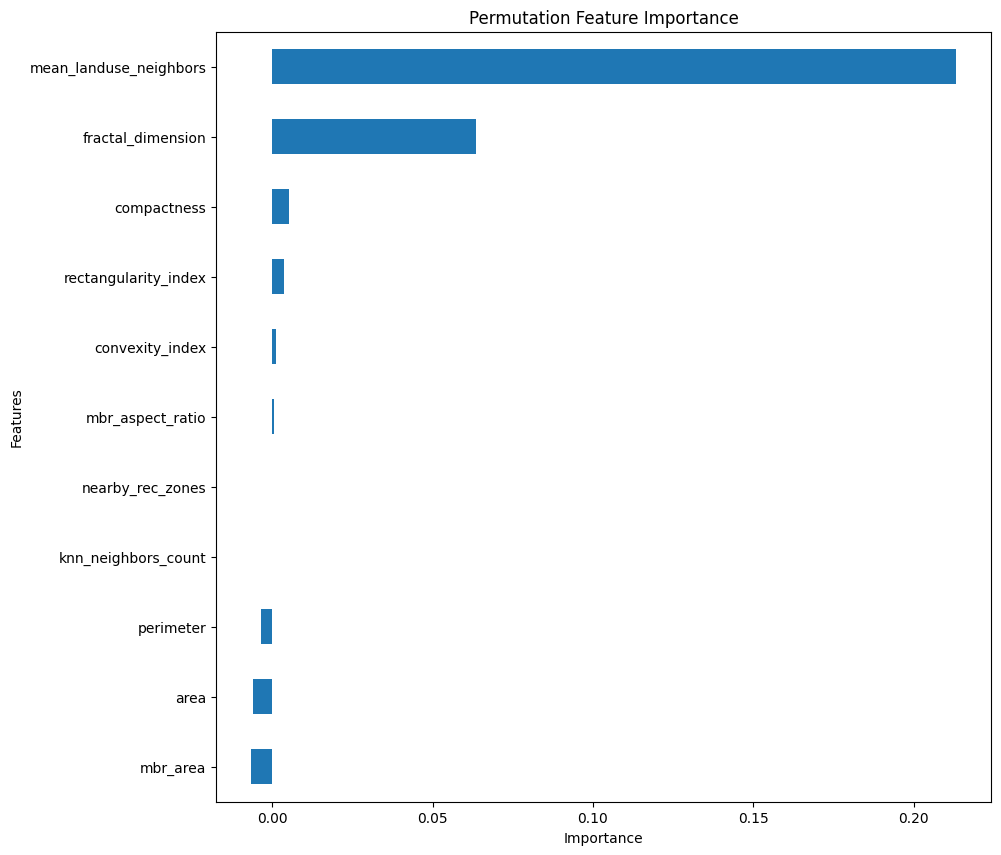

In [94]:
warnings.filterwarnings('ignore')

# Оценка важности признаков
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Формируем DataFrame
perm_importances = pd.Series(result.importances_mean, index=X_test.columns)

# Сортируем и выводим
top_features = perm_importances.sort_values(ascending=False)
print(top_features)

# Визуализация
top_features.plot(kind='barh', figsize=(10, 10))
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()


### GCN

In [31]:
import geopandas as gpd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import networkx as nx
import numpy as np
from shapely.geometry import Polygon
from sklearn.preprocessing import StandardScaler
from libpysal.weights import Queen
from libpysal import weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Финальные признаки и метки
x = torch.tensor(X_train.values, dtype=torch.float)
y = torch.tensor(y_train, dtype=torch.long)


In [33]:
def build_graph(gdf, buffer=100):
    gdf = gdf.copy()
    gdf['buffer'] = gdf.geometry.buffer(buffer)
    spatial_index = gdf.sindex
    edges = []
    for idx in gdf.index:
        row = gdf.loc[idx]
        possible = list(spatial_index.intersection(row['buffer'].bounds))
        possible = [i for i in possible if i != idx]
        for j in possible:
            if row['buffer'].intersects(gdf.geometry.loc[j]):
                edges.append((idx, j))
    return edges


In [34]:
edges = build_graph(train_gdf.reset_index(drop=True), buffer=100)
edge_index = torch.tensor(edges, dtype=torch.long)

# Объединённые признаки
X_all = pd.concat([X_train, X_test], axis=0)
X_all_tensor = torch.tensor(X_all.values, dtype=torch.float).to(device)

# Объединённый GeoDataFrame
full_gdf = pd.concat([train_gdf.reset_index(drop=True), test_gdf.reset_index(drop=True)], axis=0).reset_index(drop=True)

# Граф по всем узлам
edges_all = build_graph(full_gdf, buffer=100)
edge_index_all = torch.tensor(edges_all, dtype=torch.long).T.to(device)

# Индексы всех узлов
node_ids_all = torch.arange(X_all_tensor.shape[0], device=device)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Dropout, BatchNorm1d
from torch_geometric.nn import GCNConv, BatchNorm
    
class FeatureEncoder(torch.nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            Linear(input_dim, emb_dim),
            torch.nn.ReLU(),
            Linear(emb_dim, emb_dim)
        )

    def forward(self, x):
        return self.mlp(x)
    
class DynamicGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.feature_encoder = FeatureEncoder(in_channels, hidden_channels)
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)
        self.bn4 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.linear1 = Linear(hidden_channels, hidden_channels)
        self.linear2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.feature_encoder(x)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)        
        x = self.linear1(x)
        x = self.bn4(x)
        x = self.linear2(x)
        return x


In [37]:
num_nodes = X_all_tensor.shape[0]
node_ids = torch.arange(num_nodes).to(device)

model = DynamicGCN(
    in_channels=x.shape[1],
    hidden_channels=64,
    out_channels=len(le.classes_),
).to(device)

data = Data(x=x.to(device), edge_index=edge_index.T.to(device), y=y.to(device))
data = Data(x=x.to(device), edge_index=edge_index.T.to(device), y=y.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(451):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        pred = out.argmax(dim=1)
        acc = (pred == data.y).float().mean()
        print(f"Epoch {epoch:>3}, Loss: {loss.item():.4f}, Acc: {acc.item():.4f}")


Epoch   0, Loss: 1.4269, Acc: 0.3300
Epoch  50, Loss: 0.8869, Acc: 0.6426
Epoch 100, Loss: 0.8256, Acc: 0.6700
Epoch 150, Loss: 0.8211, Acc: 0.6750
Epoch 200, Loss: 0.7919, Acc: 0.6911
Epoch 250, Loss: 0.7786, Acc: 0.6961
Epoch 300, Loss: 0.7347, Acc: 0.7116
Epoch 350, Loss: 0.7300, Acc: 0.7183
Epoch 400, Loss: 0.7092, Acc: 0.7273
Epoch 450, Loss: 0.7022, Acc: 0.7260


In [38]:
# Предсказания модели с эмбеддингами узлов
model.eval()
with torch.no_grad():
    out_all = model(X_all_tensor, edge_index_all)
    pred_all = out_all.argmax(dim=1).cpu().numpy()

# Предсказания: индексы test идут сразу после train
test_preds = pred_all[len(X_train):]
test_labels = le.inverse_transform(test_preds)

# Добавляем в test_gdf
test_gdf['predicted_land_use'] = test_labels

from sklearn.metrics import classification_report
print(classification_report(y_test, test_preds, target_names=le.classes_))


               precision    recall  f1-score   support

      bus_res       0.72      0.67      0.69      1162
   industrial       0.33      0.13      0.19       100
rec_spec_agri       0.54      0.51      0.52       418
    transport       0.74      0.83      0.78      1548

     accuracy                           0.71      3228
    macro avg       0.58      0.53      0.55      3228
 weighted avg       0.70      0.71      0.70      3228

